# Proses Training Dataset Colorful

### Importing Library

In [2]:
import os
import csv
import numpy as np

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from matplotlib import pyplot as plt
import pandas as pd

### Load Data fitur From CSV

In [16]:
# read csv file directory
df = pd.read_csv('data/dataset_color.csv')

fitur = []
for i in range(len(df['fitur0'])): # loop baris / jumlah data
    temp = []
    for f in range(20): # loop  kolom / jumlah fitur
        temp.append(df['fitur'+str(f)][i])
    fitur.append(temp)
    
fitur = np.array(fitur)
target = np.array([k for k in df['kelas']])


In [17]:
print(fitur, target)

[[ 85055   8172  13081 ...   2005   1021   5782]
 [ 28650 105170  25987 ...    360  12984    684]
 [ 88669  27481   2367 ...   1616   1189   1024]
 ...
 [ 38015   8628  40532 ...   2398  28003   3457]
 [ 20584  13019   7969 ...   1131   2253    994]
 [130198   4542   3947 ...    785   3089   5860]] [ 1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1  1  1  1  1  1  1]


## Adaboost Classification

In [19]:
num_feature = len(fitur[0]) # jumlah fitur 20
m = len(target) # jumlah data 176
T = 10 # jumlah iterasi 10

### Function Step Adaboost

In [20]:
def weight_error_predictor(w, y_pred, y_target):
    sumNot = 0
    for i in range(m):
        if y_pred[i] != y_target[i]:
            sumNot += w[i]
    return sumNot/w.sum()
      

In [21]:
def weight_predictor(rj, lrate=1):
    '''
    Semakin besar weighted error akan membuat bobot predictor semakin 
    rendah, dan sebaliknya.
    Bobot ini digunakan untuk update bobot tiap data pada dataset, 
    dan prediksi akhir (final aggregation)
    '''
    # np.log is ln, whereas np.log10 is your standard base 10 log.
    return lrate * np.log((1-rj)/rj)
    

In [22]:
def update_weight_predictor(w, a, y_pred, y_target):
    new_w = np.zeros(w.shape)
    for i in range(m):
        err = 0 if y_pred[i] == y_target[i] else 1
        new_w[i] = w[i] * np.exp(a*err)
    return new_w
        

### Train

In [23]:
# Membuat np array bobot awal
w = np.array([1/m for _ in range(m)])

# Membuat array bobot predictor dengan ukuran jumlah iterasi
a = np.zeros(shape=T)

# Membuat array untuk weak learner
wl = np.zeros(shape=T, dtype=object)

for t in range(T):
    # Weak Learner
    #weak_learn = LogisticRegression(random_state=0)
    weak_learn = DecisionTreeClassifier(max_depth=1)
    # Weak Learner Train
    weak_learn = weak_learn.fit(fitur, target, sample_weight=w)
    
    # weighted error dari Predictor ke-j
    y_pred = weak_learn.predict(fitur)
    rj = weight_error_predictor(w, y_pred, target)
    
    # Bobot Predictor
    aj = weight_predictor(rj, lrate=1)
    a[t] = aj
    
    # Update weight dataset
    w = update_weight_predictor(w, aj, y_pred, target)
    
    # Menambhakan weak learner ke array
    wl[t] = weak_learn 
    

In [61]:
## Saving Model
import joblib
for i, model in enumerate(wl):
    joblib.dump(model, './model/ds_tree_%s.pkl'%i)

file_a = open('./model/bbt_pred.csv', 'w')
for aj in a:
    file_a.write('%s,'%aj)

file_a.close()
    

In [24]:
print(fitur[0])
wl[5].predict([fitur[0]])
print(a)

[85055  8172 13081 49538 20881  4424  5544  1379  4329   919  2665  9067
  8647  1021 13625  1406  1439  2005  1021  5782]
[1.22377543 0.83681558 1.19817576 1.04277464 1.01224779 0.93203089
 0.93632423 0.40676802 0.61734525 0.8214544 ]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier


ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=200,algorithm="SAMME.R", learning_rate=1)
ada_clf.fit(fitur, target)
y_pred=ada_clf.predict(fitur)
print(fitur)
print(y_pred)
print(target)

### Prediksi Function

In [36]:
def predict(fitur, a, weak_learn):
    # Mendapatkan hipotesis dari weak learn
    y_pred = np.array([wl.predict(fitur) for wl in weak_learn], dtype=int)
    # Hasil Prediksi
    return np.sign(np.dot(a, y_pred))[0]
        

### Testing Data

In [37]:
# Membuat tapungan
prediksi = np.zeros(shape=m)

for i in range(m):
    pr = predict([fitur[i]], a, wl)
    prediksi[i] = pr


In [38]:
print(fitur[0])

[0.35439583 0.03405    0.05450417 0.20640833 0.08700417 0.01843333
 0.0231     0.00574583 0.0180375  0.00382917 0.01110417 0.03777917
 0.03602917 0.00425417 0.05677083 0.00585833 0.00599583 0.00835417
 0.00425417 0.02409167]


In [39]:
print(prediksi)
print(target)

[ 1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.
 -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1.
 -1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.]
[ 1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1

### Confusion Matrix

[[100   7]
 [ 11  58]]


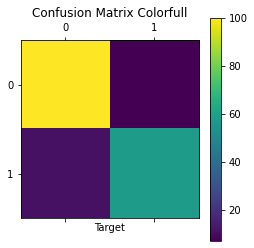

In [40]:
cm = confusion_matrix(prediksi, target)
print(cm)
plt.matshow(cm)
plt.title("Confusion Matrix Colorfull")
plt.xlabel("Prediksi")
plt.xlabel("Target")
cb = plt.colorbar()

In [16]:
print("F1-skor Keseluruhan")
precision = precision_score(target, prediksi)
recall = recall_score(target, prediksi)
print("Precisision = ", precision)
print("Recall      = ", recall)

F1-skor Keseluruhan
Precisision =  0.8405797101449275
Recall      =  0.8923076923076924


In [17]:
c = 0
for i in range(m):
    if prediksi[i] == target[i]:
        c += 1
print(c/m)

0.8977272727272727
